Total number of variables............................:      303
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      202
Total number of inequality constraints...............:      101
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      101
        inequality constraints with only upper bounds:        0


Number of Iterations....: 30

                                   (scaled)                 (unscaled)
Objective...............:   1.7272176262167206e+03    1.7272176262167206e+03
Dual infeasibility......:   2.1316282072803006e-13    2.1316282072803006e-13
Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

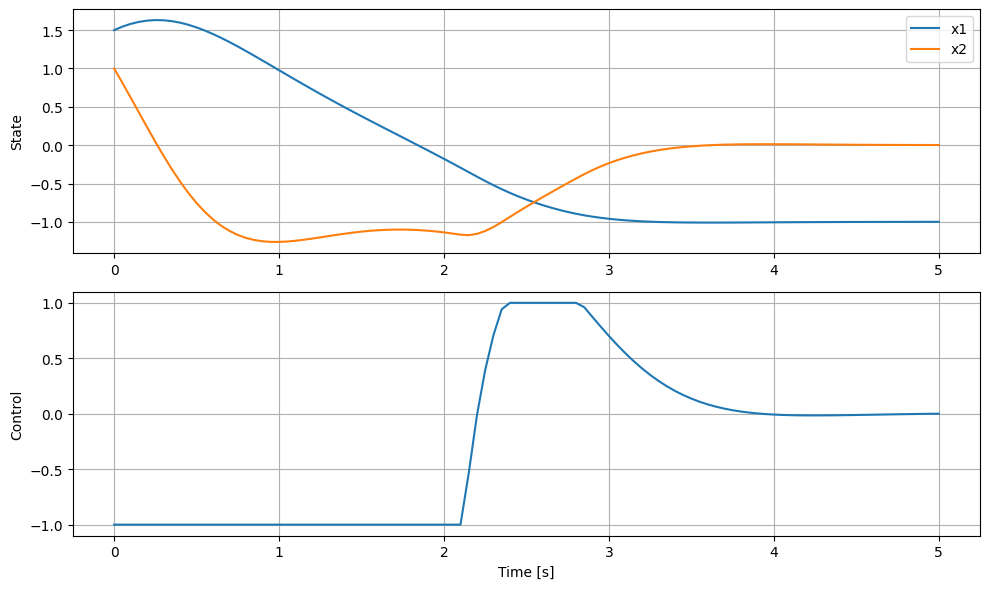

In [16]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Duffing dynamics
def duffing_dynamics(x, u, delta=0.8):
    x1, x2 = x[0], x[1]
    x1_dot = x2
    x2_dot = -delta * x2 + x1 - x1**3 + u[0]
    return ca.vertcat(x1_dot, x2_dot)

# Hermite-Simpson defect constraint
def hermite_simpson_constraint(xk, xkp1, uk, ukp1, dt):
    fk = duffing_dynamics(xk, uk)
    fkp1 = duffing_dynamics(xkp1, ukp1)
    xm = 0.5 * (xk + xkp1) + (dt / 8) * (fk - fkp1)
    um = 0.5 * (uk + ukp1)
    fm = duffing_dynamics(xm, um)
    return xk + (dt / 6) * (fk + 4 * fm + fkp1) - xkp1

# Problem setup
N = 100
dt = 0.05
nx, nu = 2, 1
Q = np.diag([10.0, 1.0])
R = np.diag([0.1])

# Optimization setup
opti = ca.Opti()
X = opti.variable(nx, N+1)
U = opti.variable(nu, N+1)
x0 = opti.parameter(nx)
x_goal = opti.parameter(nx)

# Collocation constraints
for k in range(N):
    defect = hermite_simpson_constraint(X[:, k], X[:, k+1], U[:, k], U[:, k+1], dt)
    opti.subject_to(defect == 0)

# Initial state constraint
opti.subject_to(X[:, 0] == x0)

# opti.subject_to(X[0, :] ** 2 >= 1.0)

# Control bounds
opti.subject_to(opti.bounded(-1.0, U, 1.0))

# Cost function
cost = 0
for k in range(N):
    cost += ca.mtimes([(X[:, k] - x_goal).T, Q, (X[:, k] - x_goal)])
    cost += ca.mtimes([U[:, k].T, R, U[:, k]])
opti.minimize(cost)

# Solver setup
opti.solver("ipopt", {
    "print_time": False,
    "ipopt": {
        "print_level": 3,
        "sb": "yes"  # Suppress banner
    }
})

# Initial condition
x0_val = np.array([1.5, 1.0])
opti.set_value(x0, x0_val)

xf_val = np.array([-1.0, 0.0])
opti.set_value(x_goal, xf_val)

# ts = np.linspace(0, 1, N+1)
# X_init = (1 - ts) * x0_val[:, None] + ts * xf_val[:, None]  # linear interpolation

# U_init = np.zeros((nu, N+1))  # initialize control to zeros

# opti.set_initial(X, X_init)
# opti.set_initial(U, U_init)

# Solve
sol = opti.solve()
X_sol = sol.value(X)
U_sol = sol.value(U)

# Plot
ts = np.linspace(0, N * dt, N+1)
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(ts, X_sol[0], label="x1")
plt.plot(ts, X_sol[1], label="x2")
plt.ylabel("State")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(ts, U_sol, label="u")
plt.xlabel("Time [s]")
plt.ylabel("Control")
plt.grid()
plt.tight_layout()
plt.show()